**Data Loading**

In [143]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

In [144]:
# Pre-processed Data
food_inspections = pd.read_pickle("food.pkl")

### Studying the Violations

We check if there are entries with no violations. If there is no violation, nothing was detected in those restaurants.

In [145]:
food_inspections['Violations'].isnull().values.any()

True

In [146]:
print('Total number of entries in the dataset: {0}'.format(food_inspections.shape[0]))

Total number of entries in the dataset: 147455


In [147]:
print('Total number of entries with no violations in the dataset: {0}'\
      .format(food_inspections[food_inspections['Violations'].isnull()].shape[0]))
per = food_inspections[food_inspections['Violations'].isnull()].shape[0]/food_inspections.shape[0]
print('Corresponding the following percentage of entries: {0:.2f}'\
      .format(per))

Total number of entries with no violations in the dataset: 21814
Corresponding the following percentage of entries: 0.15


We fill those NaN values with the tag 'No Violation' for better readibility during counting. We will then inspect the violations data to see its shape.

In [148]:
food_inspections['Violations'].fillna('No Violation', inplace=True)

We observe that the violations are referenced using a 'number', a 'description' and a comment for more specificities. In our case, we don't need the comment part so we delete it. The 'Violations' column can as well contain more than one violation type, we can split those into arrays and create a new violation-based dataset.

In [149]:
food_inspections['Violations'] = food_inspections.Violations.apply(lambda x: x.split('- Comments:')[0])

In [150]:
food_inspections['Violations'] = np.array(food_inspections.Violations.apply(lambda x: x.split('|')))

**Create Violation based dataset**

In [151]:
# Convert from geopandas to pandas to use explode
food_inspections = pd.DataFrame(food_inspections)

In [152]:
violations = food_inspections.explode('Violations')\
                    .rename(columns={'Violations':'Violation'}) \
                    .reset_index(drop=True) \
                    .dropna(subset=['Violation']) \
                    .set_index('Violation') \
                    .reset_index()

**Violation ID and Delete No Violation**

In [153]:
# Create the Violation ID column. The number at beginning gives the type.
violations['Violation ID'] = violations['Violation']
violations['Violation ID'] = violations['Violation ID'].apply(lambda x: x.split('.')[0])
violations = violations[violations['Violation ID'] != 'No Violation']

**Count using ID**

In [154]:
def get_counts(df):
    """
    Get the number of violations per violation type 
    :param df: violations dataframe
    :return: the counts with the frequency (frequency for each type)
    """
    df_count = df[['Violation','Violation ID','Inspection ID']].groupby(['Violation','Violation ID'])\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)\
                    .rename(columns={'Inspection ID':'Occurence'})

    df_count.reset_index(inplace=True)
    df_count.sort_values(by='Violation ID', ascending=True, inplace=True)
    
    df_count = df_count[['Violation ID','Occurence']]
    df_count = df_count.groupby('Violation ID', as_index=False).sum()
    sum_ = df_count['Occurence'].sum()
    df_count['Frequency'] = df_count['Occurence']/sum_ 
    df_count.sort_values(by='Occurence', ascending=False, inplace=True)
    df_count.index = df_count['Violation ID']
    
    return df_count

In [155]:
violation_count = get_counts(violations)
violation_count.head()

,Violation ID,Occurence,Frequency
Violation ID,,,
32,32,22826,0.181031
33,33,15555,0.123365
3,3,11930,0.094616
34,34,8966,0.071109
30,30,8735,0.069276


**Plotting Violations**

We find below the 12 Most common violation from the dataframe.

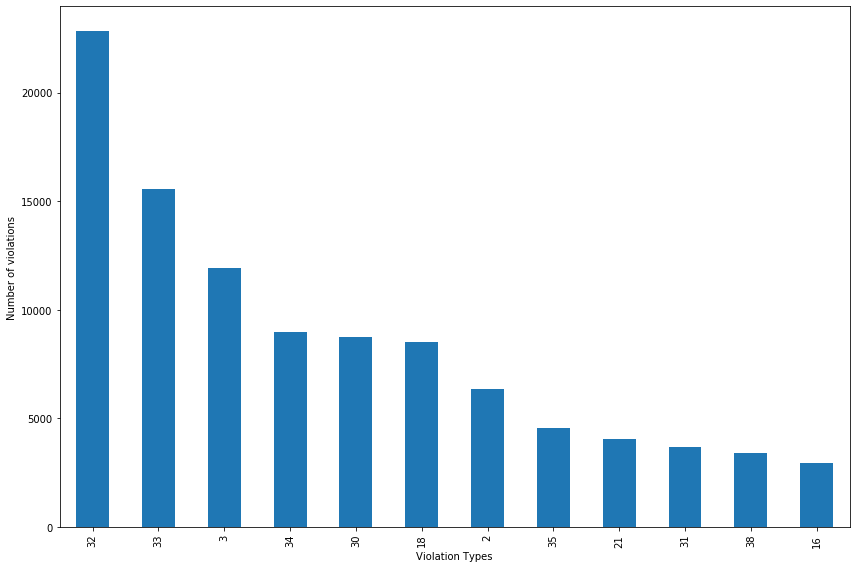

In [156]:
# Plot 13 top values
ax = violation_count.Occurence.iloc[0:12].plot(kind='bar',figsize = [12,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

We observe that some violations are much more frequent than others. We should see now the relation between the violations and the risks associated with each inspection. 

**Separe violations by results**

We kept the inspections with the 'Fail', 'Pass' and 'Pass with Conditions' outcomes. We shall see now, how they are distributed among the violations types. As we have seen in the description of the dataset. Some of the violations are considered to be 'serious', 'critical' or 'not serious'.

In [157]:
violations.Results.unique()

array(['Fail', 'Pass w/ Conditions', 'Pass'], dtype=object)

In [158]:
# Create different datasets filtering by the results
violations_fail = violations[violations['Results'] == 'Fail']
violations_pass = violations[violations['Results'] == 'Pass']
violations_cond = violations[violations['Results'] == 'Pass w/ Conditions']

In [159]:
# Get the counts for each violation
violations_fail_count = get_counts(violations_fail)
violations_pass_count = get_counts(violations_pass)
violations_cond_count = get_counts(violations_cond)

In [160]:
violations_fail_count.head()

,Violation ID,Occurence,Frequency
Violation ID,,,
18,18,8365,0.278332
3,3,3441,0.114494
2,2,3362,0.111865
16,16,1963,0.065316
29,29,1717,0.057130


In [161]:
violations_pass_count.head()

,Violation ID,Occurence,Frequency
Violation ID,,,
32,32,22318,0.308426
33,33,15360,0.212269
34,34,8854,0.122359
30,30,8603,0.118890
35,35,4493,0.062091


In [162]:
violations_cond_count.head()

,Violation ID,Occurence,Frequency
Violation ID,,,
3,3,8455,0.357143
21,21,3557,0.150249
2,2,2927,0.123638
5,5,1025,0.043296
16,16,920,0.038861


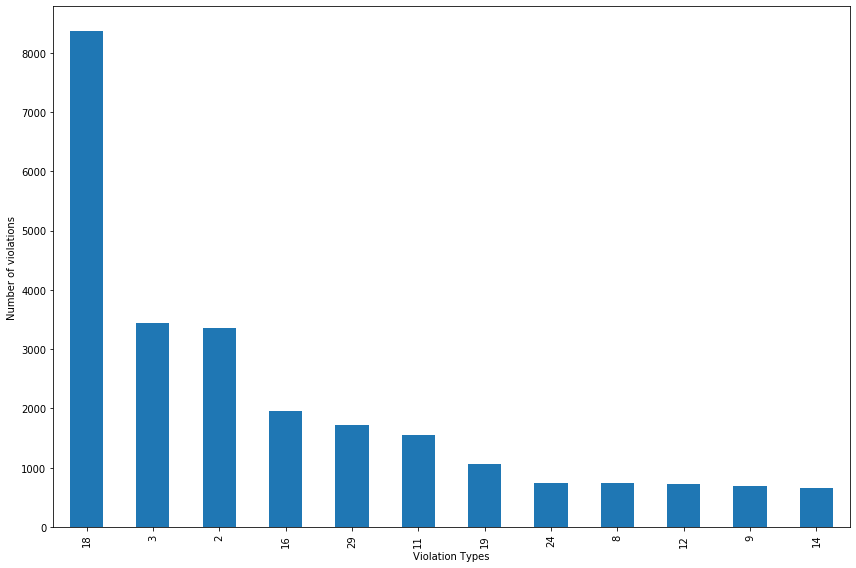

In [163]:
# Plot 12 top values for the critical violations that caused the facility to fail the inspection 
ax = violations_fail_count.Occurence.iloc[0:11].plot(kind='bar',figsize = [12,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

**Merge the results together for more plots**

In [164]:
merged = violation_count.merge(violations_pass_count, left_index=True, right_index=True)
merged.drop('Violation ID_x', inplace=True, axis=1)
merged.drop('Violation ID_y', inplace=True, axis=1)
merged.rename(columns={"Occurence_x": "Occurence All", "Frequency_x": "Frequency All"}, inplace=True)
merged.rename(columns={"Occurence_y": "Occurence Pass", "Frequency_y": "Frequency Pass"}, inplace=True)

merged = merged.merge(violations_fail_count, left_index=True, right_index=True)
merged.drop('Violation ID', inplace=True, axis=1)
merged.rename(columns={"Occurence": "Occurence Fail", "Frequency": "Frequency Fail"}, inplace=True)

merged = merged.merge(violations_cond_count, left_index=True, right_index=True)
merged.drop('Violation ID', inplace=True, axis=1)
merged.rename(columns={"Occurence": "Occurence w/ Cond.", "Frequency": "Frequency w/ Cond."}, inplace=True)

merged.head()

,Occurence All,Frequency All,Occurence Pass,Frequency Pass,Occurence Fail,Frequency Fail,Occurence w/ Cond.,Frequency w/ Cond.
Violation ID,,,,,,,,
32,22826,0.181031,22318,0.308426,341,0.011346,167,0.007054
33,15555,0.123365,15360,0.212269,117,0.003893,78,0.003295
3,11930,0.094616,34,0.000470,3441,0.114494,8455,0.357143
34,8966,0.071109,8854,0.122359,71,0.002362,41,0.001732
30,8735,0.069276,8603,0.118890,63,0.002096,69,0.002915


In [165]:
sub_merged = merged[['Occurence All','Occurence Pass','Occurence Fail', 'Occurence w/ Cond.']].copy()
sub_merged.rename(columns={'Occurence All':'All', 'Occurence Pass': "Pass", 'Occurence Fail': "Fail", \
                           "Occurence w/ Cond.":'Pass w/ cond'}, inplace=True)
sub_merged.head()

,Pass,Fail,Pass w/ cond
Violation ID,,,
32,22318,341,167
33,15360,117,78
3,34,3441,8455
34,8854,71,41
30,8603,63,69


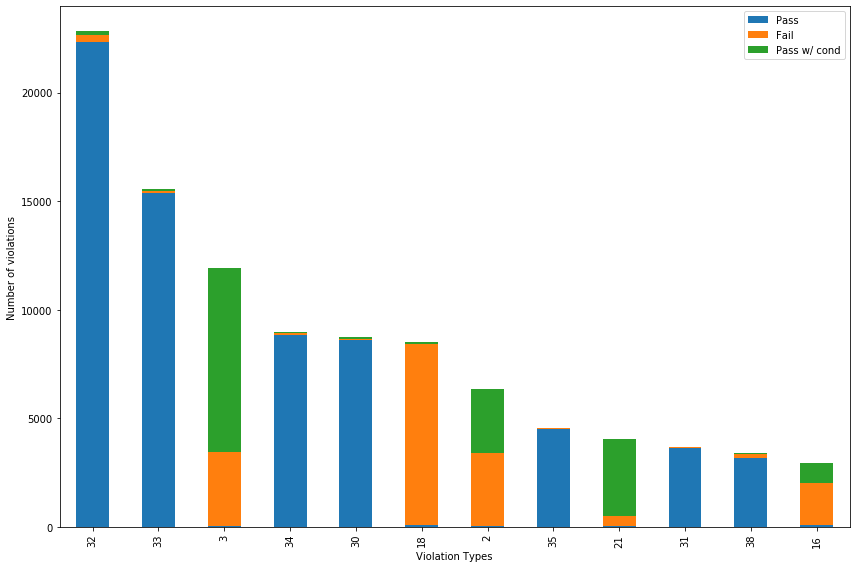

In [179]:
# Same graph as earlier but with the decomposition
sub_merged.sort_values(by='All', inplace=True, ascending=False)
ax = sub_merged.iloc[0:11,1:].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

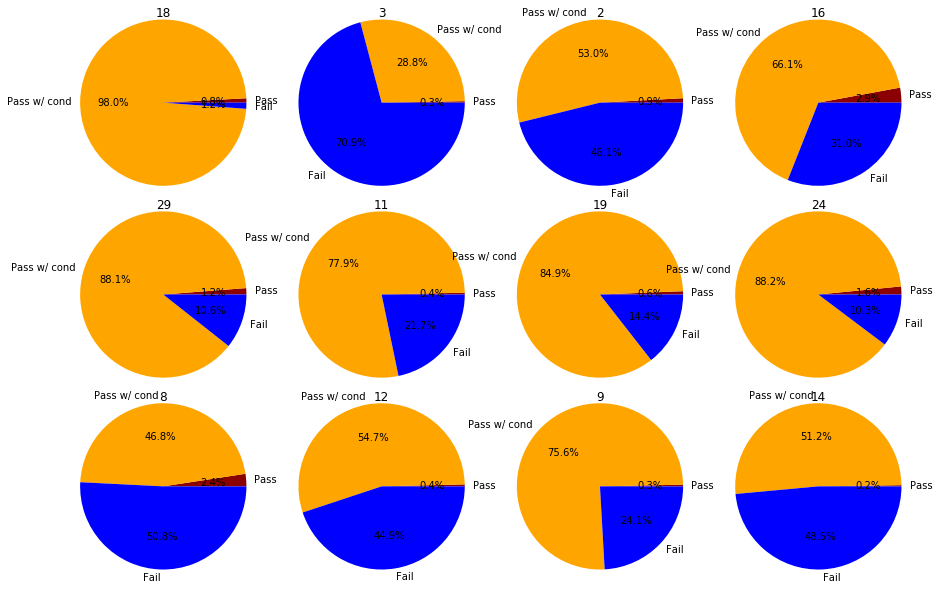

In [180]:
# Sorting by most frequent fails. Top 12 charts below
sub_merged.sort_values(by='Fail', inplace=True, ascending=False)
violation_list = sub_merged.index

labels = ['Pass', 'Pass w/ cond', 'Fail']
fig, ax= plt.subplots(3, 4, figsize=(15,10))

first=0
for i in range(3):
    for j in range(4):
        
        ax[i,j].pie(sub_merged.iloc[first,1:].to_list(), labels = labels, radius = 1.3,
                    autopct='%1.1f%%', colors=["darkred","orange","blue"])
        ax[i,j].set_title(violation_list[first])
        first += 1

plt.show()

Pie charts for the distributions of each associated results of the most frequent serious violations resulting in a 'Fail'

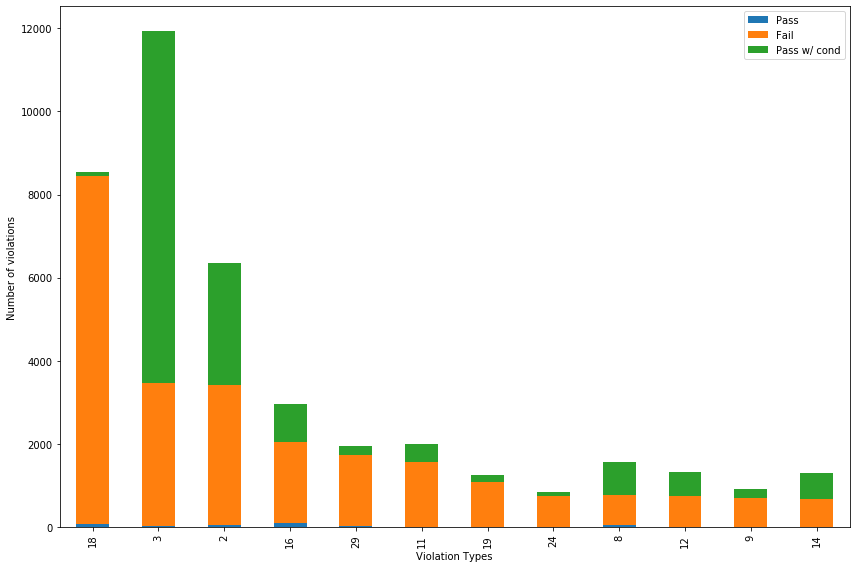

In [181]:
# Also two 12 for the most frequent 'fails'
ax = sub_merged.iloc[0:11,1:].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

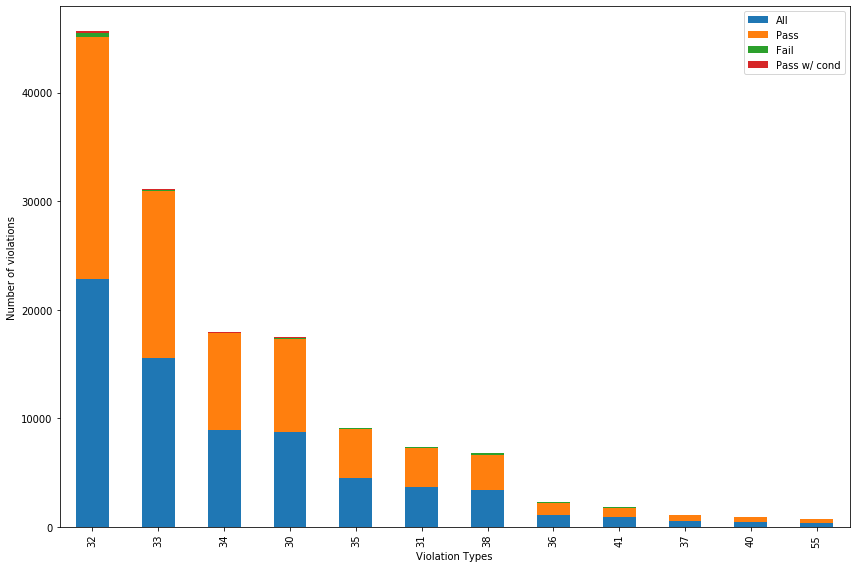

In [182]:
# Plot for the most frequent 'Pass'
sub_merged.sort_values(by='Pass', inplace=True, ascending=False)
ax = sub_merged.iloc[0:11].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

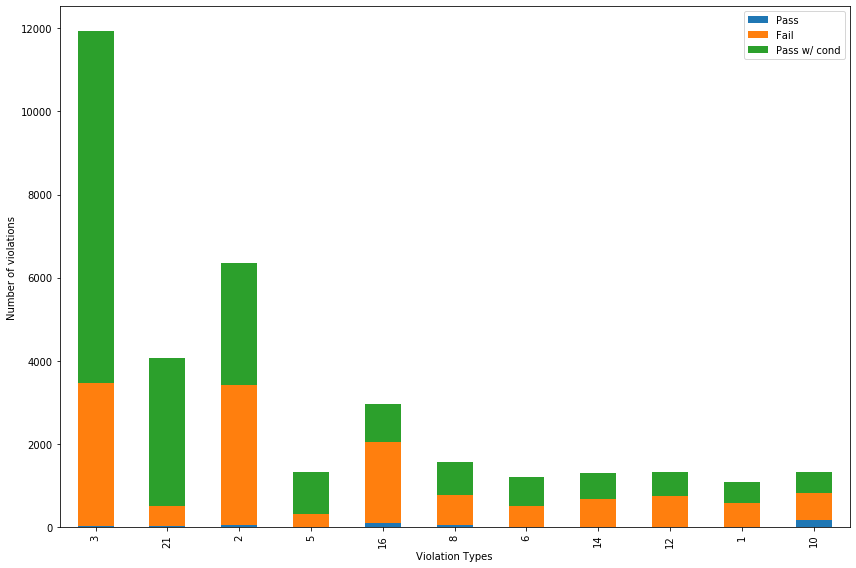

In [184]:
# Plot for the most frequent 'Pass with condition'
sub_merged.sort_values(by='Pass w/ cond', inplace=True, ascending=False)
ax = sub_merged.iloc[0:11,1:].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

**Violations per establishment**

In [185]:
# Loading the target dataset containing only the restaurants
restaurants_top5 = pd.read_pickle("restaurants.pkl")

In [186]:
# Merge with the violations result from earlier
restaurants_top5 = restaurants_top5.merge(violations[['Inspection ID','Violation ID']], on='Inspection ID')

In [195]:
# Selection of the most useful parameters
violation_resto = restaurants_top5.groupby(['AKA Name','DBA Name', 'License #','Longitude', 'Latitude'])\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)

# Taking only the 'Violation ID' count
violation_resto = violation_resto[['Violation ID']]
violation_resto.rename(columns={'Violation ID':'Viol. Count'},inplace=True)
violation_resto.reset_index(inplace=True)

In [198]:
#Plotting the restaurants having the most violations
violation_resto.head(8)

,AKA Name,DBA Name,License #,Longitude,Latitude,Viol. Count
0,MCDONALDS,MCDONALD'S,1490035.0,-87.626813,41.769155,37
1,MCDONALDS,McDONALD'S,1302136.0,-87.622915,41.794794,32
2,SUBWAY,SUBWAY,1594765.0,-87.705855,41.867667,29
3,MCDONALDS,MCDONALD'S,33706.0,-87.705734,41.866514,27
4,MCDONALDS,McDONALDS,1519152.0,-87.615441,41.778597,27
5,MCDONALDS,MCDONALD'S,1874347.0,-87.683386,41.775117,26
6,DUNKIN DONUTS,DUNKIN DONUTS,32534.0,-87.667674,41.904524,26
7,MCDONALDS,MCDONALD'S RESTAURANT,1678414.0,-87.664337,41.778361,25


'Mc Donalds' and 'Subway' have the restaurants with the higher violation counts.

In [199]:
violation_resto[violation_resto['DBA Name'] == 'MCDONALD\'S'].head()

,AKA Name,DBA Name,License #,Longitude,Latitude,Viol. Count
0,MCDONALDS,MCDONALD'S,1490035.0,-87.626813,41.769155,37
3,MCDONALDS,MCDONALD'S,33706.0,-87.705734,41.866514,27
5,MCDONALDS,MCDONALD'S,1874347.0,-87.683386,41.775117,26
16,MCDONALDS,MCDONALD'S,1514130.0,-87.621449,41.830953,20
19,MCDONALDS,MCDONALD'S,1943516.0,-87.586437,41.775220,19
